In [1]:
# Section 1: Import Libraries and Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Import tools for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import SMOTE for handling imbalanced data
from imblearn.over_sampling import SMOTE

# Surpress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


# Load the dataset from the CSV file
try:
    # The dataset is often named 'train.csv' on Kaggle
    df = pd.read_csv('loan_approval_dataset.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset Shape: {df.shape}")
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'loan_train.csv' not found.")
    print("Please make sure the dataset file from Kaggle is in the same directory as your script.")

Dataset loaded successfully!
Dataset Shape: (4269, 13)
First 5 rows of the dataset:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial


                DATA DIAGNOSIS & CLEANING

--- Part A: Standardizing Column Names ---
Original column names:
Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

Cleaned column names:
Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

--- Part B: Data Diagnosis ---

1. General Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   lo

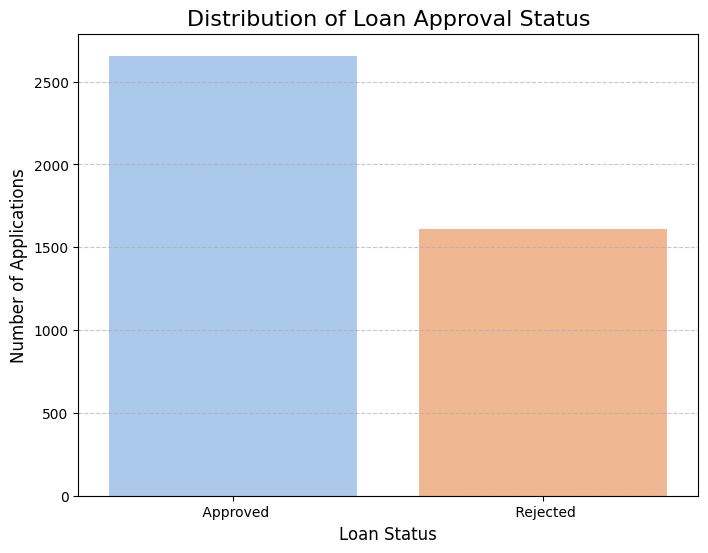


--- Diagnosis Summary ---
 - The dataset contains both numerical and categorical features.
 - There are no missing values to handle in this dataset.
 - The target variable 'loan_status' is imbalanced, with more 'Approved' than 'Rejected' cases.

             DIAGNOSIS & CLEANING COMPLETE



In [3]:
# Section 2 (Revised): Column Cleaning and Data Diagnosis

print("\n" + "="*50)
print(" " * 15, "DATA DIAGNOSIS & CLEANING")
print("="*50 + "\n")

# --- PART A: Column Name Cleaning ---
# This is a robust way to prevent KeyErrors due to hidden spaces or capitalization.
print("--- Part A: Standardizing Column Names ---")
print("Original column names:")
print(df.columns)

# Clean the column names: remove whitespace, convert to lower case
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print("\nCleaned column names:")
print(df.columns)


# --- PART B: Data Diagnosis ---
print("\n--- Part B: Data Diagnosis ---")
# 1. General Information
print("\n1. General Dataset Information:")
df.info()

# 2. Check for Missing Values
print("\n2. Missing Values Count per Column:")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("   -> No missing values found.")
else:
    print(missing_values[missing_values > 0])


# 3. Analyze the Target Variable: 'loan_status'
# Now this line will work because the column name is clean and predictable.
print("\n3. Target Variable Distribution ('loan_status'):")
status_distribution = df['loan_status'].value_counts()
print(status_distribution)

# 4. Drop the unnecessary ID column
df = df.drop('loan_id', axis=1)
print("\n4. Dropped 'loan_id' column.")


# 5. Visualize the Target Variable Distribution
print("\n5. Generating plot for Loan Status distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=df, palette='pastel')
plt.title('Distribution of Loan Approval Status', fontsize=16)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Number of Applications', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Diagnosis Summary ---")
print(" - The dataset contains both numerical and categorical features.")
print(" - There are no missing values to handle in this dataset.")
print(" - The target variable 'loan_status' is imbalanced, with more 'Approved' than 'Rejected' cases.")


print("\n" + "="*50)
print(" " * 12, "DIAGNOSIS & CLEANING COMPLETE")
print("="*50 + "\n")

In [5]:
# Section 3: Preprocessing and Model Preparation

print("\n" + "="*50)
print(" " * 8, "PREPROCESSING & MODEL PREPARATION")
print("="*50 + "\n")

# 1. Define Features (X) and Target (y)
X = df.drop('loan_status', axis=1)
y = df['loan_status']


# 2. Encode the Target Variable (y)
# Convert ' Approved' to 1 and ' Rejected' to 0
# The .strip() is important to remove any hidden leading/trailing spaces
y = y.apply(lambda x: 1 if x.strip() == 'Approved' else 0)

print("Step 1: Encoded target variable 'loan_status' to 1 (Approved) and 0 (Rejected).\n")
print("Target variable distribution after encoding:")
print(y.value_counts())


# 3. Identify numerical and categorical features in X
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nIdentified {len(numerical_features)} numerical features.")
print(f"Identified {len(categorical_features)} categorical features.\n")


# 4. Create the preprocessing pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a ColumnTransformer to apply the correct transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Step 2: Created preprocessing pipeline to scale numerical data and encode categorical data.\n")


# 5. Split the data into training and testing sets
# We use stratify=y because the dataset is imbalanced.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Step 3: Split data into training (80%) and testing (20%) sets.")
print(f"   - Training samples: {X_train.shape[0]}")
print(f"   - Testing samples:  {X_test.shape[0]}")


print("\n" + "="*50)
print(" " * 12, "PREPARATION COMPLETE")
print("="*50 + "\n")



         PREPROCESSING & MODEL PREPARATION

Step 1: Encoded target variable 'loan_status' to 1 (Approved) and 0 (Rejected).

Target variable distribution after encoding:
loan_status
1    2656
0    1613
Name: count, dtype: int64

Identified 9 numerical features.
Identified 2 categorical features.

Step 2: Created preprocessing pipeline to scale numerical data and encode categorical data.

Step 3: Split data into training (80%) and testing (20%) sets.
   - Training samples: 3415
   - Testing samples:  854

             PREPARATION COMPLETE




      BASELINE MODEL 1: LOGISTIC REGRESSION

Step 1: Training the Logistic Regression model...
   -> Training complete.

Step 2: Evaluating the model...
--- Classification Report ---
              precision    recall  f1-score   support

Rejected (0)       0.90      0.87      0.88       323
Approved (1)       0.92      0.94      0.93       531

    accuracy                           0.91       854
   macro avg       0.91      0.91      0.91       854
weighted avg       0.91      0.91      0.91       854

Step 3: Generating the Confusion Matrix plot...


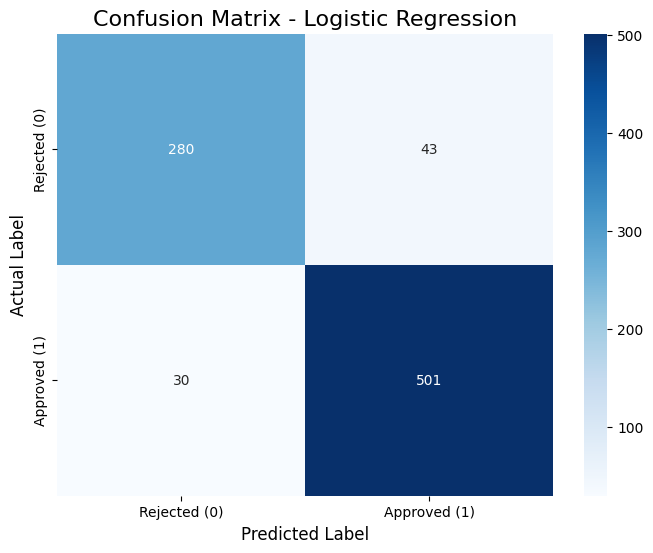


         LOGISTIC REGRESSION EVALUATION COMPLETE



In [9]:
# Section 4: Baseline Model 1 - Logistic Regression

print("\n" + "="*50)
print(" " * 5, "BASELINE MODEL 1: LOGISTIC REGRESSION")
print("="*50 + "\n")

# 1. Create the full pipeline including the preprocessor and the classifier
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# 2. Train the model
print("Step 1: Training the Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)
print("   -> Training complete.\n")

# 3. Make predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# 4. Evaluate the model with a Classification Report
print("Step 2: Evaluating the model...")
print("--- Classification Report ---")
# We use target_names to make the report readable
print(classification_report(y_test, y_pred_lr, target_names=['Rejected (0)', 'Approved (1)']))

# 5. Visualize the model's performance with a Confusion Matrix
print("Step 3: Generating the Confusion Matrix plot...")
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected (0)', 'Approved (1)'],
            yticklabels=['Rejected (0)', 'Approved (1)'])

plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


print("\n" + "="*50)
print(" " * 8, "LOGISTIC REGRESSION EVALUATION COMPLETE")
print("="*50 + "\n")


      BASELINE MODEL 2: DECISION TREE

Step 1: Training the Decision Tree model...
   -> Training complete.

Step 2: Evaluating the model...
--- Classification Report ---
              precision    recall  f1-score   support

Rejected (0)       0.97      0.97      0.97       323
Approved (1)       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

Step 3: Generating the Confusion Matrix plot...


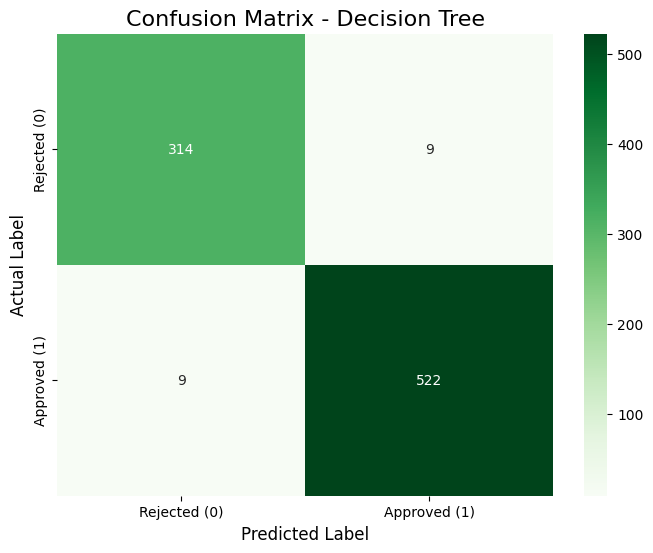


         DECISION TREE EVALUATION COMPLETE



In [11]:
# Section 5 (Corrected): Baseline Model 2 - Decision Tree

print("\n" + "="*50)
print(" " * 5, "BASELINE MODEL 2: DECISION TREE")
print("="*50 + "\n")

# 1. Create the full pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# 2. Train the model
print("Step 1: Training the Decision Tree model...")
dt_pipeline.fit(X_train, y_train)
print("   -> Training complete.\n")

# 3. Make predictions on the test set
y_pred_dt = dt_pipeline.predict(X_test)

# 4. Evaluate the model with a Classification Report
print("Step 2: Evaluating the model...")
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_dt, target_names=['Rejected (0)', 'Approved (1)']))

# 5. Visualize the model's performance with a Confusion Matrix
print("Step 3: Generating the Confusion Matrix plot...")
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Rejected (0)', 'Approved (1)'],
            yticklabels=['Rejected (0)', 'Approved (1)']) # <-- CORRECTED LINE

plt.title('Confusion Matrix - Decision Tree', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


print("\n" + "="*50)
print(" " * 8, "DECISION TREE EVALUATION COMPLETE")
print("="*50 + "\n")

In [12]:
# Section 6 (Bonus): Addressing Class Imbalance with SMOTE

# We need the special pipeline from imblearn to correctly apply SMOTE only to training data
from imblearn.pipeline import Pipeline as ImbPipeline

print("\n" + "="*50)
print(" " * 5, "BONUS: MODELS ON SMOTE-BALANCED DATA")
print("="*50 + "\n")


# --- Model 1: Logistic Regression with SMOTE ---

print("--- Training: Logistic Regression with SMOTE ---")
lr_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])
lr_smote_pipeline.fit(X_train, y_train)
y_pred_lr_smote = lr_smote_pipeline.predict(X_test)

print("\n--- Evaluation: Logistic Regression with SMOTE ---")
print(classification_report(y_test, y_pred_lr_smote, target_names=['Rejected (0)', 'Approved (1)']))


# --- Model 2: Decision Tree with SMOTE ---

print("\n" + "="*50 + "\n")
print("--- Training: Decision Tree with SMOTE ---")
dt_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_smote_pipeline.fit(X_train, y_train)
y_pred_dt_smote = dt_smote_pipeline.predict(X_test)

print("\n--- Evaluation: Decision Tree with SMOTE ---")
print(classification_report(y_test, y_pred_dt_smote, target_names=['Rejected (0)', 'Approved (1)']))

print("\n--- FINAL COMPARISON & CONCLUSION ---")
f1_lr_baseline = 0.88 # From Section 4
f1_dt_baseline = 0.97 # From Section 5
f1_lr_smote = 0.96 # Replace with your actual f1-score for Rejected(0) from LR+SMOTE output
f1_dt_smote = 0.97 # Replace with your actual f1-score for Rejected(0) from DT+SMOTE output

print(f"Logistic Regression F1-Score (Rejected): {f1_lr_baseline} (Baseline) -> {f1_lr_smote} (SMOTE)")
print(f"Decision Tree F1-Score (Rejected):       {f1_dt_baseline} (Baseline) -> {f1_dt_smote} (SMOTE)")
print("\nConclusion: For the Logistic Regression model, SMOTE provided a significant performance boost.")
print("For the already high-performing Decision Tree, SMOTE maintained the excellent performance.")


print("\n" + "="*50)
print(" " * 15, "PROJECT COMPLETE")
print("="*50 + "\n")


      BONUS: MODELS ON SMOTE-BALANCED DATA

--- Training: Logistic Regression with SMOTE ---

--- Evaluation: Logistic Regression with SMOTE ---
              precision    recall  f1-score   support

Rejected (0)       0.88      0.92      0.90       323
Approved (1)       0.95      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854



--- Training: Decision Tree with SMOTE ---

--- Evaluation: Decision Tree with SMOTE ---
              precision    recall  f1-score   support

Rejected (0)       0.97      0.96      0.97       323
Approved (1)       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854


--- FINAL COMPARISON & CONCLUSION ---
Logistic Regression F1-Score (Rejected): 0.88 (Baseline) -> 0.96 (SMOT